In [1]:
import ast
import matplotlib.pyplot as plt
import multirecording_spikeanalysis as spike
import numpy as np
import os
import pandas as pd
import pickle
# import spikeanal as spike
from matplotlib_venn import venn3
from pathlib import Path

cols = ['condition', 'session_dir', 'all_subjects', 'tone_start_timestamp', 'tone_stop_timestamp']

# Load the data
df = pd.read_excel('combined_excel_file.xlsx', usecols=cols, engine='openpyxl')

df2 = df.dropna() # Drop the rows missing data
df3 = df2.copy()
df3['all_subjects'] = df3['all_subjects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) # Make the 'all_subjects' column readable as a list
df4 = df3[df3['all_subjects'].apply(lambda x: len(x) < 3)] # Ignore novel sessions for now

# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df4.iterrows():
    session_dir = row['session_dir']
    subjects = row['all_subjects']
    condition = row['condition']

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split('_subj_')[0]

    for subject in subjects:
        subject_formatted = subject.replace('.', '-')
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        new_df_data.append({
            'session_dir': session_dir,
            'subject': subject,
            'subj_recording': subj_recording,
            'condition': condition if condition in ['rewarded', 'omission', 'both_rewarded', 'tie'] else ('win' if str(condition) == str(subject) else 'lose'),
            'tone_start_timestamp': row['tone_start_timestamp'],
            'tone_stop_timestamp': row['tone_stop_timestamp']
        })

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

# Prepare timestamp_dicts from new_df
timestamp_dicts = {}
for _, row in new_df.iterrows():
    key = row['subj_recording']
    condition = row['condition']
    timestamp_start = int(row['tone_start_timestamp']) // 20
    timestamp_end = int(row['tone_stop_timestamp']) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {cond: [] for cond in ['rewarded', 'win', 'lose', 'omission', 'both_rewarded', 'tie']}
    timestamp_dicts[key][condition].append(tuple_val)

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)

In [2]:
# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'recordings' / 'All_Alone_Comp'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged.rec
<class 'numpy.ndarray'>
20230618_100636_standard_comp_to_omission_D2_subj_1-1_t1b2L_box2_merged.rec
<class 'numpy.ndarray'>
20230618_100636_standard_comp_to_omission_D2_subj_1-4_t4b3L_box1_merged.rec
<class 'numpy.ndarray'>
20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged.rec
<class 'numpy.ndarray'>
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged.rec
<class 'numpy.ndarray'>
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged.rec
<class 'numpy.ndarray'>
20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged.rec
<class 'numpy.ndarray'>
20240320_142408_alone_comp_subj_3-1_t6b6_merged.rec
<class 'numpy.ndarray'>
20240320_142408_alone_comp_subj_3-3_t5b5_merged.rec
<class 'numpy.ndarray'>
20240320_171038_alone_

In [3]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject
        
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 250, ignore_freq = 0.5)

All set to analyze


In [4]:
event_and_pre_event_spikes_df = spike_analysis.generate_event_dataframe()

In [5]:
win_lose_reward_df = event_and_pre_event_spikes_df[
    (event_and_pre_event_spikes_df['Event name'] == 'win') |
    (event_and_pre_event_spikes_df['Event name'] == 'lose') |
    (event_and_pre_event_spikes_df['Event name'] == 'rewarded')
]

In [6]:
# Identify the columns to be averaged (all columns starting with 'Pre-event timebin' and 'Event timebin')
timebin_columns = [col for col in win_lose_reward_df.columns if 'Pre-event timebin' in col or 'Event timebin' in col]

# Group by 'Recording', 'Event name', 'Unit number' and compute the mean for the timebin columns
event_pre_event_mean_fr = win_lose_reward_df.groupby(['Recording', 'Event name', 'Unit number'])[timebin_columns].mean().reset_index()

# Display the new DataFrame
event_pre_event_mean_fr

,Recording,Event name,Unit number,Pre-event timebin 1,Pre-event timebin 2,Pre-event timebin 3,Pre-event timebin 4,Pre-event timebin 5,Pre-event timebin 6,Pre-event timebin 7,...,Event timebin 31,Event timebin 32,Event timebin 33,Event timebin 34,Event timebin 35,Event timebin 36,Event timebin 37,Event timebin 38,Event timebin 39,Event timebin 40
0,20230617_115521_standard_comp_to_omission_D1_s...,lose,3,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,0.000000,0.000000
1,20230617_115521_standard_comp_to_omission_D1_s...,lose,4,4.000000,2.000000,4.000000,10.000000,10.000000,14.000000,8.000000,...,2.000000,4.000000,8.000000,4.000000,8.000000,2.000000,10.000000,2.000000,2.000000,6.000000
2,20230617_115521_standard_comp_to_omission_D1_s...,lose,5,2.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,...,2.000000,0.000000,0.000000,2.000000,2.000000,2.000000,0.000000,0.000000,2.000000,2.000000
3,20230617_115521_standard_comp_to_omission_D1_s...,lose,6,4.000000,6.000000,2.000000,0.000000,0.000000,8.000000,2.000000,...,2.000000,2.000000,2.000000,8.000000,2.000000,4.000000,6.000000,6.000000,16.000000,18.000000
4,20230617_115521_standard_comp_to_omission_D1_s...,lose,17,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,2.000000,2.000000,0.000000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,49,10.666667,9.333333,5.333333,4.666667,8.666667,4.000000,6.666667,...,6.666667,4.666667,6.000000,2.666667,6.000000,11.333333,10.000000,8.000000,12.000000,14.000000
693,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,54,4.000000,7.333333,4.666667,2.666667,6.000000,5.333333,7.333333,...,9.333333,7.333333,6.666667,5.333333,9.333333,10.666667,8.666667,8.666667,8.000000,9.333333
694,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,68,8.000000,5.333333,6.000000,3.333333,4.000000,4.666667,4.000000,...,2.000000,4.000000,6.000000,4.000000,4.666667,4.666667,6.666667,8.666667,5.333333,4.666667
695,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,75,0.000000,0.000000,1.333333,0.666667,0.000000,0.000000,1.333333,...,0.666667,0.000000,0.000000,1.333333,6.000000,1.333333,0.666667,0.666667,4.000000,0.000000


In [7]:
# Identify the columns to be averaged (all columns starting with 'Pre-event timebin' and 'Event timebin')
pre_event_columns = [col for col in event_pre_event_mean_fr.columns if 'Pre-event timebin' in col]
event_columns = [col for col in event_pre_event_mean_fr.columns if 'Event timebin' in col]

# Group by 'Recording', 'Event name', 'Unit number' and compute the required statistics
grouped_df = event_pre_event_mean_fr.groupby(['Recording', 'Event name', 'Unit number'])

# Calculate the mean and standard deviation for Pre-event timebin columns
pre_event_means = grouped_df[pre_event_columns].mean().mean(axis=1)
pre_event_sds = grouped_df[pre_event_columns].mean().std(axis=1)

# Calculate the mean for Event timebin columns
event_means = grouped_df[event_columns].mean().mean(axis=1)

# Calculate the Z-score for the Event mean
z_scores = (event_means - pre_event_means) / pre_event_sds

# Create the new DataFrame with the required columns
event_zscores_df = pd.DataFrame({
    'Recording': pre_event_means.index.get_level_values('Recording'),
    'Event name': pre_event_means.index.get_level_values('Event name'),
    'Unit number': pre_event_means.index.get_level_values('Unit number'),
    'Pre-event M': pre_event_means.values,
    'Pre-event SD': pre_event_sds.values,
    'Event M': event_means.values,
    'Event Z-Score': z_scores.values
})

# Reset the index to have a clean DataFrame
event_zscores_df.reset_index(drop=True, inplace=True)

# Display the new DataFrame
event_zscores_df

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score
0,20230617_115521_standard_comp_to_omission_D1_s...,lose,3,3.250000,2.993583,0.250000,-1.002144
1,20230617_115521_standard_comp_to_omission_D1_s...,lose,4,5.500000,3.289455,4.300000,-0.364802
2,20230617_115521_standard_comp_to_omission_D1_s...,lose,5,0.850000,1.271986,1.950000,0.864789
3,20230617_115521_standard_comp_to_omission_D1_s...,lose,6,3.100000,3.103348,3.800000,0.225563
4,20230617_115521_standard_comp_to_omission_D1_s...,lose,17,0.450000,0.959434,0.550000,0.104228
...,...,...,...,...,...,...,...
692,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,49,6.166667,1.961161,7.816667,0.841338
693,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,54,4.550000,1.804632,6.850000,1.274498
694,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,68,4.683333,1.697912,4.433333,-0.147240
695,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,75,0.933333,0.864626,0.683333,-0.289142


In [8]:
# Define the conditions and corresponding values
conditions = [
    (event_zscores_df['Event Z-Score'] > 1.65),
    (event_zscores_df['Event Z-Score'] < -1.65)]

values = ['increase', 'decrease']

# Apply the conditions
event_zscores_df['sig'] = np.select(conditions, values, default='not sig')

# Display the new DataFrame
event_zscores_df

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score,sig
0,20230617_115521_standard_comp_to_omission_D1_s...,lose,3,3.250000,2.993583,0.250000,-1.002144,not sig
1,20230617_115521_standard_comp_to_omission_D1_s...,lose,4,5.500000,3.289455,4.300000,-0.364802,not sig
2,20230617_115521_standard_comp_to_omission_D1_s...,lose,5,0.850000,1.271986,1.950000,0.864789,not sig
3,20230617_115521_standard_comp_to_omission_D1_s...,lose,6,3.100000,3.103348,3.800000,0.225563,not sig
4,20230617_115521_standard_comp_to_omission_D1_s...,lose,17,0.450000,0.959434,0.550000,0.104228,not sig
...,...,...,...,...,...,...,...,...
692,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,49,6.166667,1.961161,7.816667,0.841338,not sig
693,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,54,4.550000,1.804632,6.850000,1.274498,not sig
694,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,68,4.683333,1.697912,4.433333,-0.147240,not sig
695,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,75,0.933333,0.864626,0.683333,-0.289142,not sig


In [9]:
# Load the umap_df_detail.pkl file
umap_df_detail = pd.read_pickle('Newest_UMAP/umap_df_detail.pkl')

# Merge event_zscores_df with umap_df_detail based on 'Recording' and 'Unit number'
merged_df = event_zscores_df.merge(
    umap_df_detail[['recording_name', 'unit_id', 'cluster_id']],  # Only select necessary columns
    how='left',
    left_on=['Recording', 'Unit number'],
    right_on=['recording_name', 'unit_id']
)

# Create the 'putative type' column based on the 'cluster_id'
merged_df['putative type'] = merged_df['cluster_id'].apply(lambda x: 'interneuron' if x == 5 else 'pyramidal')

# Drop the unnecessary columns
merged_df = merged_df.drop(columns=['recording_name', 'unit_id', 'cluster_id'])

merged_df

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score,sig,putative type
0,20230617_115521_standard_comp_to_omission_D1_s...,lose,3,3.250000,2.993583,0.250000,-1.002144,not sig,pyramidal
1,20230617_115521_standard_comp_to_omission_D1_s...,lose,4,5.500000,3.289455,4.300000,-0.364802,not sig,pyramidal
2,20230617_115521_standard_comp_to_omission_D1_s...,lose,5,0.850000,1.271986,1.950000,0.864789,not sig,pyramidal
3,20230617_115521_standard_comp_to_omission_D1_s...,lose,6,3.100000,3.103348,3.800000,0.225563,not sig,pyramidal
4,20230617_115521_standard_comp_to_omission_D1_s...,lose,17,0.450000,0.959434,0.550000,0.104228,not sig,pyramidal
...,...,...,...,...,...,...,...,...,...
692,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,49,6.166667,1.961161,7.816667,0.841338,not sig,pyramidal
693,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,54,4.550000,1.804632,6.850000,1.274498,not sig,pyramidal
694,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,68,4.683333,1.697912,4.433333,-0.147240,not sig,pyramidal
695,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,75,0.933333,0.864626,0.683333,-0.289142,not sig,pyramidal


In [10]:
# Group by 'Recording' and 'Unit number' and aggregate the required columns
grouped = merged_df.groupby(['Recording', 'Unit number']).agg({
    'Event name': lambda x: list(x),
    'sig': lambda x: list(x),
    'putative type': 'first'  # Assuming 'putative type' is consistent within each group
}).reset_index()

# Initialize lists to store the 'sig events' and 'not sig events'
sig_events = []
not_sig_events = []

# Iterate over the grouped DataFrame to populate the lists
for index, row in grouped.iterrows():
    sig_list = []
    not_sig_list = []
    for event_name, sig in zip(row['Event name'], row['sig']):
        if sig != 'not sig':
            sig_list.append(event_name)
        else:
            not_sig_list.append(event_name)
    sig_events.append(sig_list)
    not_sig_events.append(not_sig_list)

# Create the final DataFrame
units_df = pd.DataFrame({
    'Recording': grouped['Recording'],
    'Unit number': grouped['Unit number'],
    'sig events': sig_events,
    'not sig events': not_sig_events,
    'putative type': grouped['putative type']
})

# Display the new DataFrame
units_df

,Recording,Unit number,sig events,not sig events,putative type
0,20230617_115521_standard_comp_to_omission_D1_s...,3,[],"[lose, win]",pyramidal
1,20230617_115521_standard_comp_to_omission_D1_s...,4,[],"[lose, win]",pyramidal
2,20230617_115521_standard_comp_to_omission_D1_s...,5,[],"[lose, win]",pyramidal
3,20230617_115521_standard_comp_to_omission_D1_s...,6,[],"[lose, win]",pyramidal
4,20230617_115521_standard_comp_to_omission_D1_s...,17,[],"[lose, win]",pyramidal
...,...,...,...,...,...
252,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,49,[],"[lose, rewarded, win]",pyramidal
253,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,54,[],"[lose, rewarded, win]",pyramidal
254,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,68,[],"[lose, rewarded, win]",pyramidal
255,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,75,[lose],"[rewarded, win]",pyramidal


In [11]:
units_df['sig events'].value_counts()

sig events
[]                       218
[rewarded]                10
[lose]                     9
[rewarded, win]            6
[lose, win]                5
[win]                      5
[lose, rewarded, win]      3
[lose, rewarded]           1
Name: count, dtype: int64

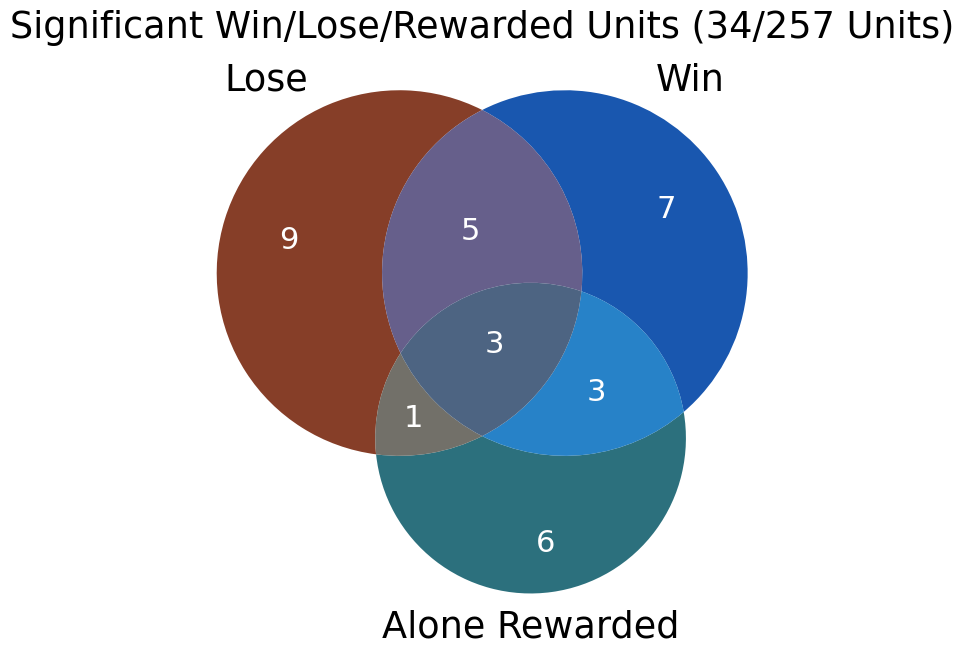

In [12]:
# Set global font size larger
plt.rcParams.update({'font.size': 22})  # Setting the font size as in the example

# Your data for the Venn diagram
labels = {
    '100': 9,      # Lose only
    '010': 7,      # Win only
    '001': 6,      # Alone Rewarded only
    '110': 5,      # Lose and Win
    '101': 1,      # Lose and Alone Rewarded
    '011': 3,      # Win and Alone Rewarded
    '111': 3       # Lose, Win, and Alone Rewarded
}

# Colors for each category
colors = ['#792910', '#0045a6', '#15616F']  # Lose, Win, Alone Rewarded

# Create the Venn diagram with less transparency
plt.figure(figsize=(8, 8))
venn = venn3(subsets=labels, set_labels=('Lose', 'Win', 'Alone Rewarded'), set_colors=colors, alpha=0.9)

# Update text colors for the numbers within the Venn diagram to white
for text in venn.subset_labels:
    if text:  # Check if the text object exists to avoid errors
        text.set_color('white')

# Adding a title to the Venn diagram
plt.title("Significant Win/Lose/Rewarded Units (34/257 Units)")

# Directory to save the files
directory = 'leo_poster'

# Check if the directory exists, and if not, create it
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the plot as SVG and JPG in the specified directory
plt.savefig(f'{directory}/win_lose_reward_venn_diagram.jpg', format='jpg', bbox_inches='tight')
plt.savefig(f'{directory}/win_lose_reward_venn_diagram.svg', format='svg', bbox_inches='tight')

# Display the plot
plt.show()
